# Visualize pymoo result
Load the pymoo result object saved with pickle and visualize it.

ONOSControllerPlacement needs to be definded to load the result object.
So, execute the following cell first.

In [1]:
#!/usr/bin/env python
import numpy as np
import networkx as nx
import math
import pickle
from pymoo.core.problem import ElementwiseProblem

class ONOSControllerPlacement(ElementwiseProblem):
    def __init__(self, num_nodes, distance_matrix, shortest_paths, graph, **kwargs):
        super().__init__(n_var=2*num_nodes, 
                         n_obj=4, 
                         n_constr=2, 
                         xl=0, xu=1, 
                         **kwargs)
        self.num_nodes = num_nodes
        self.distance_matrix = distance_matrix
        self.shortest_paths = shortest_paths
        self.graph = graph
    
    def _evaluate(self, x, out, *args, **kwargs):
        controller_nodes = x[:self.num_nodes]   # first half is controller placement
        atomix_nodes = x[self.num_nodes:]       # second half is atomix placement


        num_controller = np.sum(controller_nodes)
        num_atomix = np.sum(atomix_nodes)

        # Obj1: Minimize number of contrtoller
        f1 = num_controller

        # Obj2: Minimize number of atomix
        f2 = num_atomix

        # Obj3: Minimize average FSP
        f3 = calculate_FST(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                           self.shortest_paths)
        
        f4 = calculate_BC(self.num_nodes, 
                           controller_nodes, 
                           atomix_nodes, 
                           self.distance_matrix, 
                        #    self.shortest_paths,
                           self.graph)

        # Constr1: The number of controller is equal to or greater than 2
        g1 = 2 - num_controller

        # Constr2: The number of atomix is equal to or greater than 3
        g2 = 3 - num_atomix
        
        # Add the centrality metrix into optimazing objectives:
        # 1. Nearest controller for each switch
        # 2. The number of controlled switches for each controller should be <= limit_num_switches_controlled (limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)))
        # 3. return value should be the variance for all controller's betweenness centrality
        out["F"] = [f1, f2, f3, f4]
        out["G"] = [g1, g2]


def calculate_FST(num_nodes, controller_nodes, atomix_nodes, distance_matrix, shortest_paths):
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()
    atomix_list = np.nonzero(atomix_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        for c in controller_list:
            if distance_matrix[s][c] < delay:
                delay = distance_matrix[s][c]
                nearest_controller = c
        controller_of.append(nearest_controller)    

    # calculate average delay to atomix nodes from each controller
    average_atomix_delay_from = {}
    for c in controller_list:
        delay = []
        for a in atomix_list:
            delay.append(distance_matrix[c][a])
        average_atomix_delay_from[c] = np.mean(delay)

    # find the nearest atomix for each atomix and calculate average delay
    atomix_atomix_delays = []
    for a1 in atomix_list:
        delay = math.inf
        for a2 in atomix_list:
            if(a1 == a2):
                continue
            if distance_matrix[a1][a2] < delay:
                delay = distance_matrix[a1][a2]
        atomix_atomix_delays.append(delay)
    average_atomix_atomix_delay = np.mean(atomix_atomix_delays)
    FTSs = []
    for source in range(num_nodes):
        for distination in range(num_nodes):
            if(source == distination):
                continue
            delay = 0
            is_controlled_by_single_controller = True
            counted_controllers = []
            for s in shortest_paths[source][distination]:
                # switch-controller delay
                delay += distance_matrix[s][controller_of[s]] * 4

                # controller-atomix delay
                if(s == source):
                    delay += average_atomix_delay_from[controller_of[s]] * 2
                elif(s != distination):
                    if(controller_of[s] != controller_of[source]):
                        is_controlled_by_single_controller = False
                        if(not controller_of[s] in counted_controllers):
                            counted_controllers.append(controller_of[s])
                            delay += average_atomix_delay_from[controller_of[s]]
                else:
                    if(controller_of[s] == controller_of[source]):
                        if(not is_controlled_by_single_controller):
                            delay += average_atomix_delay_from[controller_of[s]]
                    else:
                        delay += average_atomix_delay_from[controller_of[s]] * 2
            
            # atomix-atomix delay
            delay +=  average_atomix_atomix_delay * 2
            FTSs.append(delay)

    return np.mean(FTSs)



def calculate_BC(num_nodes, controller_nodes, atomix_nodes, distance_matrix, graph):
    G = nx.Graph()
    for node1 in range(len(graph)):
        G.add_node(str(node1))
        for node2, delay in graph[node1].items():
            G.add_edge(str(node1), str(node2), weight=delay)
    
    # The list of betweenness centrality for all switches
    nodes_bc=nx.current_flow_betweenness_centrality(G, normalized=True, weight=None, dtype='float', solver='full')
    num_controller = np.sum(controller_nodes)
    num_atomix = np.sum(atomix_nodes)
    controller_list = np.nonzero(controller_nodes)[0].tolist()

    if(num_controller == 0 or num_atomix ==0):
        return math.inf

    # find the nearest controller for each switch
    controller_of = []
    limit_num_switches_controlled=int(math.ceil(num_nodes/num_controller)) # balance the number of switches controllers can control 
    switches_bc_of_controller_ = dict.fromkeys((range(num_nodes)),0) # list of sum of betweenness centrality of switches for each controller
    for s in range(num_nodes):
        delay = math.inf
        nearest_controller = None
        controlled_switches=[]
        for c in controller_list:
            # Conditions: nearest controller (with the lowest delay) && the number of switches for each controller < limit_num_switches_controlled
            if distance_matrix[s][c] < delay and controller_of.count(c) < limit_num_switches_controlled:
                delay = distance_matrix[s][c]
                nearest_controller = c
                controlled_switches.append(s)
        switches_bc_of_controller_[nearest_controller] += nodes_bc[str(s)]
        controller_of.append(nearest_controller)
    
    # Simplify switches_bc_of_controller_ (only need value for calculating variance)
    bc_array = []
    for i in switches_bc_of_controller_.values():
        bc_array.append(i)

    # return variance value can show the degree of balance within all controllers
    return np.var(bc_array)

### Load unsga3 results for all topos

In [2]:
with open('res_bc_Cogent_unsga3.pkl','rb') as f_Cogent:
    res_9_Cogent = pickle.load(f_Cogent)
with open('res_bc_UsCarrier_unsga3.pkl','rb') as f_UsCarrier:
    res_9_UsCarrier = pickle.load(f_UsCarrier)
with open('res_bc_HiberniaGlobal_unsga3.pkl','rb') as f_HiberniaGlobal:
    res_9_HiberniaGlobal = pickle.load(f_HiberniaGlobal)
with open('res_bc_Colt_unsga3.pkl','rb') as f_Colt:
    res_9_Colt = pickle.load(f_Colt)
with open('res_bc_Funet_unsga3.pkl','rb') as f_Funet:
    res_9_Funet = pickle.load(f_Funet)
with open('res_bc_Abvt_unsga3.pkl','rb') as f_Abvt:
    res_9_Abvt = pickle.load(f_Abvt)
with open('res_bc_Intellifiber_unsga3.pkl','rb') as f_Intellifiber:
    res_9_Intellifiber = pickle.load(f_Intellifiber)
with open('res_bc_TataNld_unsga3.pkl','rb') as f_TataNld:
    res_9_TataNld = pickle.load(f_TataNld)
with open('res_bc_Internode_unsga3.pkl','rb') as f_Internode:
    res_9_Internode = pickle.load(f_Internode)
with open('res_bc_Missouri_unsga3.pkl','rb') as f_Missouri:
    res_9_Missouri = pickle.load(f_Missouri)
with open('res_bc_Ion_unsga3.pkl','rb') as f_Ion:
    res_9_Ion = pickle.load(f_Ion)
with open('res_bc_Palmetto_unsga3.pkl','rb') as f_Palmetto:
    res_9_Palmetto = pickle.load(f_Palmetto)

## Hypervolume
1. Store values

In [3]:
# unsga3
F9_Cogent=res_9_Cogent.F
F9_UsCarrier=res_9_UsCarrier.F
F9_HiberniaGlobal=res_9_HiberniaGlobal.F
F9_Colt=res_9_Colt.F
F9_Funet=res_9_Funet.F
F9_Abvt=res_9_Abvt.F
F9_Intellifiber=res_9_Intellifiber.F
F9_TataNld=res_9_TataNld.F
F9_Internode=res_9_Internode.F
F9_Missouri=res_9_Missouri.F
F9_Ion=res_9_Ion.F
F9_Palmetto=res_9_Palmetto.F

# # Nadir Point from 9 Algorithms: 
# ref_point = [1.81000000e+02 6.20000000e+01 3.92281875e+03 1.70537209e+00]
# # Nadir Point from 4 Algorithms: 
# ref_point = [160.  77.  inf  inf]
# # Nadir Point from all (13) Algorithms: 
# ref_point = [181.  77.  inf  inf]

ref_point = [181, 77, 3922.81875, 1.70537209]

hist_F9_Cogent = []
hist_F9_UsCarrier = []
hist_F9_HiberniaGlobal = []
hist_F9_Colt = []
hist_F9_Funet = []
hist_F9_Abvt = []
hist_F9_Intellifiber = []
hist_F9_TataNld = []
hist_F9_Internode = []
hist_F9_Missouri = []
hist_F9_Ion = []
hist_F9_Palmetto = []


for algo9_Cogent in res_9_Cogent.history:
    opt9_Cogent = algo9_Cogent.opt
    feas9_Cogent = np.where(opt9_Cogent.get("feasible"))[0]
    hist_F9_Cogent.append(opt9_Cogent.get("F")[feas9_Cogent])
for algo9_UsCarrier in res_9_UsCarrier.history:
    opt9_UsCarrier = algo9_UsCarrier.opt
    feas9_UsCarrier = np.where(opt9_UsCarrier.get("feasible"))[0]
    hist_F9_UsCarrier.append(opt9_UsCarrier.get("F")[feas9_UsCarrier])
for algo9_HiberniaGlobal in res_9_HiberniaGlobal.history:
    opt9_HiberniaGlobal = algo9_HiberniaGlobal.opt
    feas9_HiberniaGlobal = np.where(opt9_HiberniaGlobal.get("feasible"))[0]
    hist_F9_HiberniaGlobal.append(opt9_HiberniaGlobal.get("F")[feas9_HiberniaGlobal])
for algo9_Colt in res_9_Colt.history:
    opt9_Colt = algo9_Colt.opt
    feas9_Colt = np.where(opt9_Colt.get("feasible"))[0]
    hist_F9_Colt.append(opt9_Colt.get("F")[feas9_Colt])
for algo9_Funet in res_9_Funet.history:
    opt9_Funet = algo9_Funet.opt
    feas9_Funet = np.where(opt9_Funet.get("feasible"))[0]
    hist_F9_Funet.append(opt9_Funet.get("F")[feas9_Funet])
for algo9_Abvt in res_9_Abvt.history:
    opt9_Abvt = algo9_Abvt.opt
    feas9_Abvt = np.where(opt9_Abvt.get("feasible"))[0]
    hist_F9_Abvt.append(opt9_Abvt.get("F")[feas9_Abvt])
for algo9_Intellifiber in res_9_Intellifiber.history:
    opt9_Intellifiber = algo9_Intellifiber.opt
    feas9_Intellifiber = np.where(opt9_Intellifiber.get("feasible"))[0]
    hist_F9_Intellifiber.append(opt9_Intellifiber.get("F")[feas9_Intellifiber])
for algo9_TataNld in res_9_TataNld.history:
    opt9_TataNld = algo9_TataNld.opt
    feas9_TataNld = np.where(opt9_TataNld.get("feasible"))[0]
    hist_F9_TataNld.append(opt9_TataNld.get("F")[feas9_TataNld])
for algo9_Internode in res_9_Internode.history:
    opt9_Internode = algo9_Internode.opt
    feas9_Internode= np.where(opt9_Internode.get("feasible"))[0]
    hist_F9_Internode.append(opt9_Internode.get("F")[feas9_Internode])
for algo9_Missouri in res_9_Missouri.history:
    opt9_Missouri = algo9_Missouri.opt
    feas9_Missouri = np.where(opt9_Missouri.get("feasible"))[0]
    hist_F9_Missouri.append(opt9_Missouri.get("F")[feas9_Missouri])
for algo9_Ion in res_9_Ion.history:
    opt9_Ion = algo9_Ion.opt
    feas9_Ion = np.where(opt9_Ion.get("feasible"))[0]
    hist_F9_Ion.append(opt9_Ion.get("F")[feas9_Ion])
for algo9_Palmetto in res_9_Palmetto.history:
    opt9_Palmetto = algo9_Palmetto.opt
    feas9_Palmetto = np.where(opt9_Palmetto.get("feasible"))[0]
    hist_F9_Palmetto.append(opt9_Palmetto.get("F")[feas9_Palmetto])

2. Calculate hypervolume and merge them (Mean value) for unsga3 algorithm

In [4]:
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array(ref_point))

hv_9_Cogent = [metric.do(_F9_Cogent) for _F9_Cogent in hist_F9_Cogent]
hv_9_UsCarrier = [metric.do(_F9_UsCarrier) for _F9_UsCarrier in hist_F9_UsCarrier]
hv_9_HiberniaGlobal = [metric.do(_F9_HiberniaGlobal) for _F9_HiberniaGlobal in hist_F9_HiberniaGlobal]
hv_9_Colt = [metric.do(_F9_Colt) for _F9_Colt in hist_F9_Colt]
hv_9_Funet = [metric.do(_F9_Funet) for _F9_Funet in hist_F9_Funet]
hv_9_Abvt = [metric.do(_F9_Abvt) for _F9_Abvt in hist_F9_Abvt]
hv_9_Intellifiber = [metric.do(_F9_Intellifiber) for _F9_Intellifiber in hist_F9_Intellifiber]
hv_9_TataNld = [metric.do(_F9_TataNld) for _F9_TataNld in hist_F9_TataNld]
hv_9_Internode = [metric.do(_F9_Internode) for _F9_Internode in hist_F9_Internode]
hv_9_Missouri = [metric.do(_F9_Missouri) for _F9_Missouri in hist_F9_Missouri]
hv_9_Ion = [metric.do(_F9_Ion) for _F9_Ion in hist_F9_Ion]
hv_9_Palmetto = [metric.do(_F9_Palmetto) for _F9_Palmetto in hist_F9_Palmetto]

# unsga3
hv_9 = [(hv_Cogent + hv_UsCarrier + hv_HiberniaGlobal + hv_Colt + hv_Funet + hv_Abvt + hv_Intellifiber + hv_TataNld + hv_Internode + hv_Missouri + hv_Ion + hv_Palmetto) / 12 for hv_Cogent, hv_UsCarrier, hv_HiberniaGlobal, hv_Colt, hv_Funet, hv_Abvt, hv_Intellifiber, hv_TataNld, hv_Internode, hv_Missouri, hv_Ion, hv_Palmetto in zip(hv_9_Cogent, hv_9_UsCarrier, hv_9_HiberniaGlobal, hv_9_Colt, hv_9_Funet, hv_9_Abvt, hv_9_Intellifiber, hv_9_TataNld, hv_9_Internode, hv_9_Missouri, hv_9_Ion, hv_9_Palmetto)]

The hypervolumn for Cogent:
[0.0, 0.0, 0.0, 469826.73165604466, 455422.6495636657, 1874249.7430932622, 3113958.4533534036, 3342353.8469655076, 3071981.906395015, 3072060.8711505425, 5019514.59063973, 4767258.6490509445, 4769412.01725003, 4785626.3149156375, 6371768.1392873535, 6374354.817215399, 6435620.807651331, 7335007.6136914985, 7287840.878709587, 6964932.643522405, 7581149.395669227, 7596157.377794137, 7581528.199882603, 7621657.078935008, 7049243.67434644, 8363476.969299772, 8475695.797263753, 8442454.449595798, 8528429.992205508, 9116525.820864113, 9078064.070746614, 10032086.003436157, 11409571.309373956, 11431799.087182991, 11655165.831859363, 11657777.079951996, 11675322.125071812, 13079399.703980675, 13084365.036849542, 13083564.115192467, 13099551.63183541, 13669360.20039103, 14187317.786712937, 13972603.081266353, 14590394.65563301, 15085385.151278537, 14952957.952132965, 15168802.427723818, 15228379.97305686, 15361153.58002949, 15366178.066462025, 17124279.61860378, 1567

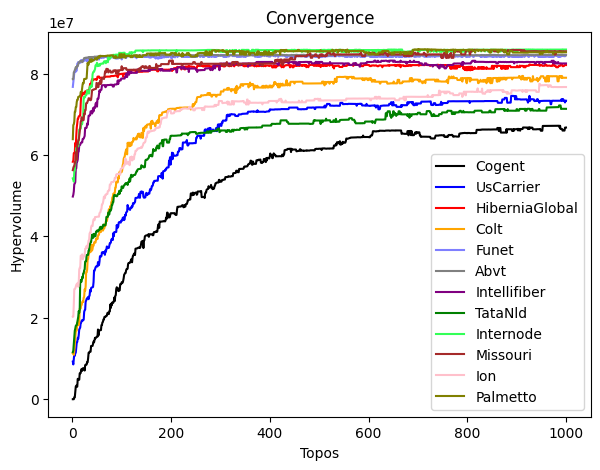

In [5]:
print('The hypervolumn for Cogent:')
print(hv_9_Cogent)
print('The hypervolumn for UsCarrier:')
print(hv_9_UsCarrier)
print('The hypervolumn for HiberniaGlobal:')
print(hv_9_HiberniaGlobal)
print('The hypervolumn for Colt:')
print(hv_9_Colt)
print('The hypervolumn for Funet:')
print(hv_9_Funet)
print('The hypervolumn for Abvt:')
print(hv_9_Abvt)
print('The hypervolumn for Intellifiber:')
print(hv_9_Intellifiber)
print('The hypervolumn for TataNld:')
print(hv_9_TataNld)
print('The hypervolumn for Internode:')
print(hv_9_Internode)
print('The hypervolumn for Missouri:')
print(hv_9_Missouri)
print('The hypervolumn for Ion:')
print(hv_9_Ion)
print('The hypervolumn for Palmetto:')
print(hv_9_Palmetto)

# Show all hv for each topo
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))
plt.plot(list(range(1, len(hv_9_Cogent)+1)), hv_9_Cogent,  color='black', label='Cogent')
plt.plot(list(range(1, len(hv_9_UsCarrier)+1)), hv_9_UsCarrier,  color='blue', label='UsCarrier')
plt.plot(list(range(1, len(hv_9_HiberniaGlobal)+1)), hv_9_HiberniaGlobal,  color='red', label='HiberniaGlobal')
plt.plot(list(range(1, len(hv_9_Colt)+1)), hv_9_Colt,  color='orange', label='Colt')
plt.plot(list(range(1, len(hv_9_Funet)+1)), hv_9_Funet,  color=(0, 0, 1, 0.5), label='Funet')
plt.plot(list(range(1, len(hv_9_Abvt)+1)), hv_9_Abvt,  color='gray', label='Abvt')
plt.plot(list(range(1, len(hv_9_Intellifiber)+1)), hv_9_Intellifiber,  color='purple', label='Intellifiber')
plt.plot(list(range(1, len(hv_9_TataNld)+1)), hv_9_TataNld,  color='green', label='TataNld')
plt.plot(list(range(1, len(hv_9_Internode)+1)), hv_9_Internode,  color='#33FF57', label='Internode')
plt.plot(list(range(1, len(hv_9_Missouri)+1)), hv_9_Missouri,  color='brown', label='Missouri')
plt.plot(list(range(1, len(hv_9_Ion)+1)), hv_9_Ion,  color='pink', label='Ion')
plt.plot(list(range(1, len(hv_9_Palmetto)+1)), hv_9_Palmetto,  color='olive', label='Palmetto')
plt.title("Convergence")
plt.xlabel("Topos")
plt.ylabel("Hypervolume")
plt.legend()
plt.show()

In [6]:
print('The aveage of hypervolumn for unsga3:')
print(hv_9)

The aveage of hypervolumn for unsga3:
[40847853.57286117, 41353180.23103311, 42217584.59948938, 43451602.897033244, 44030815.41825854, 44853059.06663361, 45688757.54116631, 46330093.91647595, 46805789.91354054, 47659079.13435837, 48147066.00360399, 48438776.11878214, 48863528.241737485, 49702397.08693927, 50345121.91789368, 51091141.829481296, 51959219.16093301, 52421722.71432193, 52577274.283053525, 52686631.738319814, 52912563.67993524, 53174791.611730985, 53677581.43169429, 54194328.77197665, 54412819.51180912, 55097238.03902086, 55393607.91088488, 55887642.401913404, 56138988.23505202, 56524256.86622554, 56933497.528785676, 57193387.41420457, 57617702.058770835, 57767726.120465524, 58227328.17008331, 58496634.305853814, 58601818.471845806, 58982326.0914825, 59298285.19003596, 59441213.53990569, 59604931.86607212, 59961455.623542465, 60175171.966815926, 60552750.55163341, 60611754.85023304, 60788138.63553699, 60940640.83508623, 61173236.86907796, 61303923.29791808, 61310782.11332544

3. Draw mean hypervolume for unsga3

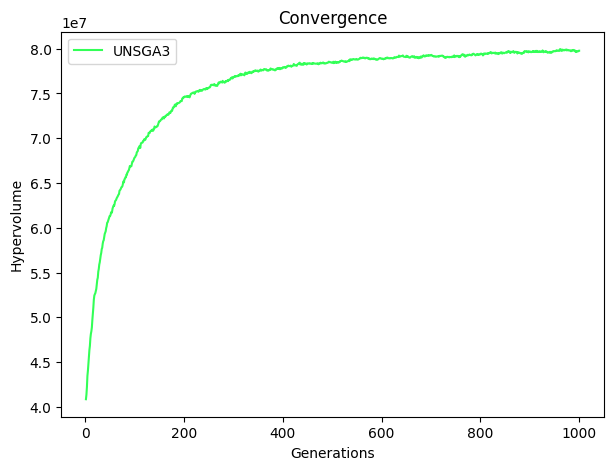

In [7]:
import matplotlib.pyplot as plt

#  Show all alogrithms' hv into a single figure
plt.figure(figsize=(7, 5))
# plt.plot(list(range(1, len(hv_1)+1)), hv_1,  color='black', label='AGEMOEA')
# plt.plot(list(range(1, len(hv_2)+1)), hv_2,  color='blue', label='AGEMOEA2')
# plt.plot(list(range(1, len(hv_3)+1)), hv_3,  color='red', label='NSGA2')
# plt.plot(list(range(1, len(hv_4)+1)), hv_4,  color='orange', label='NSGA3')
# plt.plot(list(range(1, len(hv_5)+1)), hv_5,  color=(0, 0, 1, 0.5), label='RNSGA2')
# plt.plot(list(range(1, len(hv_6)+1)), hv_6,  color='gray', label='RNSGA3')
# plt.plot(list(range(1, len(hv_7)+1)), hv_7,  color='purple', label='RVEA')
# plt.plot(list(range(1, len(hv_8)+1)), hv_8,  color='green', label='SMSEMOA')
plt.plot(list(range(1, len(hv_9)+1)), hv_9,  color='#33FF57', label='UNSGA3')
# plt.plot(list(range(1, len(hv_10)+1)), hv_10,  color='brown', label='CTAEA')
# plt.plot(list(range(1, len(hv_11)+1)), hv_11,  color='pink', label='DNSGA2')
# plt.plot(list(range(1, len(hv_12)+1)), hv_12,  color='olive', label='KGBDMOEA')
# plt.plot(list(range(1, len(hv_13)+1)), hv_13,  color='cyan', label='MOEAD')
plt.title("Convergence")
plt.xlabel("Generations") # brown,pink,#5733FF,olive,cyan,#FF5733,#33FF57
plt.ylabel("Hypervolume")
plt.legend()
plt.show()